# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [2]:
from nltk.tokenize import word_tokenize
def dict_2_df_lexicon_builder(dict_):

    df = pd.DataFrame.from_dict(dict_, orient='index').reset_index()
    df.rename(columns={'index':'words',
                       0:'values'},
              inplace=True)
    print('Shape', df.shape)
    return df



In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Volumes/GoogleDrive/My Drive/_509/M1"

# These subfolders should still work if you correctly stored the
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the lyrics data
path_ = data_location + '/lyrics/FFDP/FFDP_song_lyrics_df.csv'
ffdp_lyrics = pd.read_csv(path_)

# Read in the lyrics data
path_ = data_location + '/lyrics/OfficialRezz/OfficialRezz_song_lyrics_df.csv'
rezz_lyrics = pd.read_csv(path_)

In [5]:
# Read in the twitter data
path_ = data_location + '/twitter/FFDP_followers_data.txt'
ffdp_twitter = pd.read_csv(path_,
                           sep="\t",
                           engine='python')

path_ = data_location + '/twitter/OfficialRezz_followers_data.txt'
rezz_twitter = pd.read_csv(path_,
                           sep="\t",
                           engine='python')

## Bing Liu Lexicon build


In [32]:
bing_liu_df = {}
word_files = [negative_words_file, positive_words_file]

for file_num, file_ in enumerate(word_files):
    with open(file_, 'r', encoding="ISO-8859-1") as f:

        for idx, line in enumerate(f.readlines()):

            if line[:1] != ';' and line != '\n':

                if file_num == 0: # negative_words_file
                    bing_liu_df[line[:-1]] = 0
                else:
                    bing_liu_df[line[:-1]] = +1

bing_liu_df = dict_2_df_lexicon_builder(bing_liu_df)
bing_liu_df.sample(5)

Shape (6786, 2)


,words,values
3933,snobbish,0
5647,gutsy,1
1022,deteriorating,0
5428,expertly,1
5769,influential,1


## TidyText Lexicon

In [7]:
tidytext_df = pd.read_csv(tidy_text_file, sep='\t')
print('Shape', tidytext_df.shape)
tidytext_df.sample(10)

Shape (15133, 3)


,word,sentiment,lexicon
6773,cringed,negative,bing
6081,battered,negative,bing
8893,incomprehensible,negative,bing
6970,delays,negative,bing
6357,bump,negative,bing
1043,contamination,negative,nrc
7366,dissension,negative,bing
7090,deteriorating,negative,bing
686,busted,negative,nrc
8238,gaiety,positive,bing


## The Great Lexicon Merge
Interestingly TidyText already has Bing Liu lexicon, but I assume the included Bing Lui lexicon is different from the Tidy Text combined lexicon.

In [42]:
# bing_liu_words = bing_liu_df['words'].unique()
bing_liu_words = set(bing_liu_df['words'])

combined_df = {}
for idx, row in tidytext_df.iterrows():

    sentiment_val = row['sentiment']
    word = row['word']

    if word not in bing_liu_words:
        if sentiment_val == 'positive':
            combined_df[word] = 1
        else:
            combined_df[word] = 0

combined_df = dict_2_df_lexicon_builder(combined_df)
combined_df.sample(10)

Shape (4622, 2)


,words,values
3033,usher,1
2890,tiling,1
199,assuage,1
2590,serum,1
2385,reinstate,1
2002,opportune,1
3477,demotion,0
3860,infringing,0
963,duet,1
3533,disappear,0


In [37]:
combined_df = pd.concat([bing_liu_df, combined_df])
combined_df.shape

(11408, 2)

Well that is interesting, the original TidyText doc has roughly 5k more records.  Let's see what is going on.

In [39]:
tidytext_df['word'].value_counts()[:5]

abundance     4
confess       4
unexpected    4
malice        3
renounce      3
Name: word, dtype: int64

In [40]:
tidytext_df[tidytext_df['word'] == 'abundance']

,word,sentiment,lexicon
32,abundance,negative,nrc
33,abundance,positive,nrc
5662,abundance,positive,bing
14780,abundance,positive,loughran


Well that is interesting, NRC has abundance as both negative and positive.

We also now see why, TidyText has more records.  Some words are in multiple, if not all lexicons and some lexicons even have a word twice!

# Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [128]:
combined_word_set = set(combined_df['words'])
combined_word_dict = dict(zip(combined_df['words'], combined_df['values']))

# code below is a modified version of the "bing_liu_score" function from BTAP pg. 301
def sentiment_scorer(text):
    sentiment_score = 0
    # tokenize string
    bow = word_tokenize(text.lower())
    # remove stop words
    bow = [word for word in bow if word not in sw]

    for word in bow:
        if word in combined_word_set:
            sentiment_score += combined_word_dict[word]

    return round(sentiment_score / len(bow),4)

## FFDP Sentiment

In [126]:
ffdp_lyrics['sentiment_score'] = ffdp_lyrics['Lyrics'].apply(sentiment_scorer)
ffdp_lyrics.sample(5)

,Artist,Title,Lyrics,sentiment_score
18,FFDP,Crossing_Over,"Perched alone, he sits there broken An elde...",0.0109
4,FFDP,A_Place_To_Die,It's days like this I wish that Wish that I...,0.0349
6,FFDP,White_Knuckles,"Oh, fuck it all! Sick of being sick and ti...",0.0508
7,FFDP,Can't_Heal_You,"The deeper you get, the farther you fall do...",0.0809
14,FFDP,Dying_Breed,Round one! I swear to God I'd do it for fun...,0.0164


## Rezz Sentiment

In [127]:
rezz_lyrics['sentiment_score'] = rezz_lyrics['Lyrics'].apply(sentiment_scorer)
rezz_lyrics.sample(5)

,Artist,Title,Lyrics,sentiment_score
2,OfficialRezz,Relax,Just take a nice breath in. Exhale the brea...,0.0938
8,OfficialRezz,Your_Soul_Will_Never_Be_Released,Your soul will never be released,0.0000
5,OfficialRezz,Falling,Is it enough that I feel like I'm falling? ...,0.0000
3,OfficialRezz,Life_&_Death,Life and Death Death Death Life Death Life...,0.0000
15,OfficialRezz,Time,"Take your time Oh, take your time Oh, take ...",0.0000


## Questions

### Q1
#### Q:
Overall, which artist has the higher average sentiment per song?

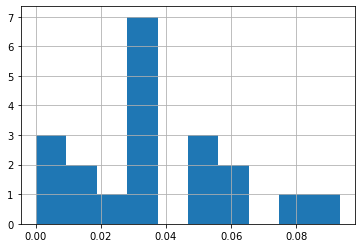

In [132]:
ffdp_lyrics['sentiment_score'].hist();

In [129]:
ffdp_lyrics['sentiment_score'].mean()

0.037695

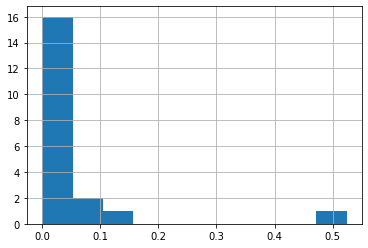

In [133]:
rezz_lyrics['sentiment_score'].hist();

In [130]:
rezz_lyrics['sentiment_score'].mean()

0.04622

#### A:


-----


#### Q2
For your first artist, what songs have the highest and lowest sentiments? Print those songs to the screen.


#### A:


_______

#### Q3
For your second artist, what songs have the highest and lowest sentiments? Print those songs to the screen.


A:

-------


Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.



# Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. 

In [ ]:
# your code here

Q: What is the average sentiment of your two artists? 

A: <!-- Your answer here --> 

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: <!-- Your answer here --> 

